<a href="https://colab.research.google.com/github/ngcheeyuan/Learner-s-Repo-for-Tensorflow/blob/main/malaria_infection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [2]:
ds , ds_info = tfds.load('malaria', 
                         as_supervised = True,
                         with_info = True)

In [3]:
ds_info

tfds.core.DatasetInfo(
    name='malaria',
    version=1.0.0,
    description='The Malaria dataset contains a total of 27,558 cell images
with equal instances of parasitized and uninfected cells from the thin blood 
smear slide images of segmented cells.',
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=27558,
    splits={
        'train': 27558,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward 
      improved malaria parasite detection in thin blood smear images},
      author={Rajaraman, Sivaramakrishnan and Antani, Sameer K and Poostchi, Mahdieh
      and Silamut, Kamolrat and Hossain, Md A and Maude, Richard J and Jaeger, 
      Stefan and Thoma, George R}

In [4]:
class_dict = {1:'uninfected',0:'infected'}

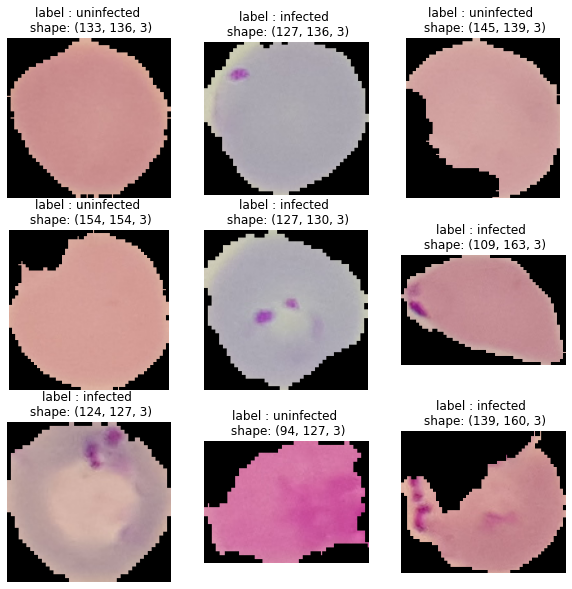

In [5]:
import random
random_index = random.randint(0,(len(ds['train'])-9))
samples = ds['train'].skip(random_index).take(9)
plt.figure(figsize = (10,10))

for index,(image,label) in enumerate(samples,1):
  plt.subplot(3,3,index)
  plt.imshow(image.numpy())
  plt.title(f'label : {class_dict[label.numpy()]} \n shape: {image.shape}')
  plt.axis(False)

In [6]:
dataset = ds['train'].take(len(ds['train']))

In [7]:
image_list = []
label_list = []

for image,label in dataset:
  image_list.append(image)
  label_list.append(label)

In [8]:
max_values = np.max([tf.reduce_max(image) for image in image_list])
min_values = np.min([tf.reduce_min(image) for image in image_list])
print('max value: ' , max_values)
print('min value: ' , min_values)

max value:  255
min value:  0


In [9]:
breath_list = [image.shape[0] for image in image_list]
height_list = [image.shape[1] for image in image_list]

In [10]:
shape_df = pd.DataFrame({'breath':breath_list,
                         'height':height_list})

In [11]:
shape_df.describe()

,breath,height
count,27558.000000,27558.000000
mean,132.983453,132.487154
std,20.619650,20.015949
min,40.000000,46.000000
25%,121.000000,121.000000
50%,130.000000,130.000000
75%,145.000000,142.000000
max,385.000000,394.000000


Model 1 : EfficientNet B0

In [12]:
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
#inputs = layers.Input(shape=input_shape, name="input_layer")
inputs =tf.keras.layers.Input(shape = (224,224,3) , name = 'input_layer')

# Add in data augmentation Sequential model as a layer

# Give base_model inputs (after augmentation) and don't train it
x = base_model(inputs, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss= tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [13]:
def scale_resize_image(image, label):
    image = tf.image.resize(image, (224, 224)) # Resizing the image to 224x224 dimention
    return (image, label)

dataset = ds['train'].map(scale_resize_image)
batched_prefetched_dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [14]:
len(batched_prefetched_dataset)-603

259

In [15]:
train_data = batched_prefetched_dataset.take(603)
test_data = batched_prefetched_dataset.skip(603).take(259)

In [16]:
history = model_1.fit(train_data,
                      epochs = 5,
                      validation_data = test_data)

Epoch 1/5
603/603 [==============================] - 142s 221ms/step - loss: 0.2204 - accuracy: 0.9195 - val_loss: 0.1634 - val_accuracy: 0.9436
Epoch 2/5
603/603 [==============================] - 129s 215ms/step - loss: 0.1477 - accuracy: 0.9475 - val_loss: 0.1449 - val_accuracy: 0.9499
Epoch 3/5
603/603 [==============================] - 130s 216ms/step - loss: 0.1352 - accuracy: 0.9521 - val_loss: 0.1371 - val_accuracy: 0.9512
Epoch 4/5
603/603 [==============================] - 130s 215ms/step - loss: 0.1287 - accuracy: 0.9539 - val_loss: 0.1325 - val_accuracy: 0.9532
Epoch 5/5
603/603 [==============================] - 129s 214ms/step - loss: 0.1244 - accuracy: 0.9556 - val_loss: 0.1294 - val_accuracy: 0.9540


In [17]:
def plot_loss_curves(history):
  df = pd.DataFrame(history.history)
  df['epochs'] = range(1,len(df)+1)
  
  plt.figure(figsize = (10,7))
  plt.subplot(1,2,1)
  plt.plot(df['epochs'] , df['accuracy'] , label = 'accuracy')
  plt.plot(df['epochs'] , df['val_accuracy'], label = 'val_accuracy')
  plt.legend()
  plt.subplot(1,2,2)
  plt.plot(df['epochs'] , df['loss'] , label = 'loss')
  plt.plot(df['epochs'] , df['val_loss'] , label = 'val_loss')
  plt.legend()

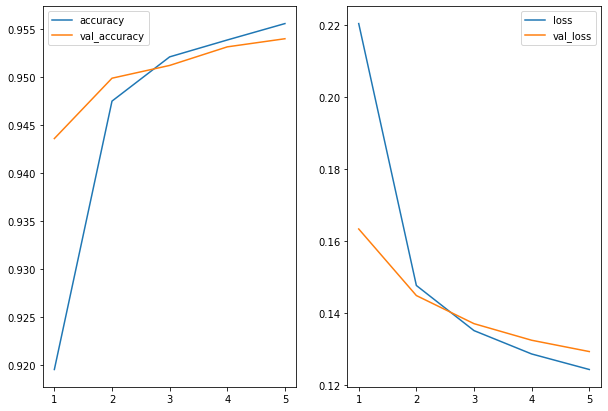

In [18]:
plot_loss_curves(history)

Model 2 : EfficientNetB0 with fine tuning

In [31]:
model_2 = tf.keras.models.clone_model(model_1)

In [38]:
base_model.trainable = True
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Create input layer
#inputs = layers.Input(shape=input_shape, name="input_layer")
inputs =tf.keras.layers.Input(shape = (224,224,3) , name = 'input_layer')

# Add in data augmentation Sequential model as a layer

# Give base_model inputs (after augmentation) and don't train it
x = base_model(inputs, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)

# Make a model with inputs and outputs
model_2 = keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss= tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [39]:
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fdf44c63a10> True
<keras.engine.functional.Functional object at 0x7fdecba35050> True
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7fde03c217d0> True
<keras.layers.core.dense.Dense object at 0x7fdecba3bb90> True


In [40]:
for index,layer in enumerate(model_2.layers[1].layers):
  print(index,layer,layer.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x7fdf44ca28d0> False
1 <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7fdf44cb7050> False
2 <keras.layers.preprocessing.normalization.Normalization object at 0x7fdecbe1ce90> False
3 <keras.layers.convolutional.ZeroPadding2D object at 0x7fdecb19f5d0> False
4 <keras.layers.convolutional.Conv2D object at 0x7fdecb18f4d0> False
5 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fdf44c6ac50> False
6 <keras.layers.core.activation.Activation object at 0x7fdecbe1c410> False
7 <keras.layers.convolutional.DepthwiseConv2D object at 0x7fdecbcea0d0> False
8 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fdecba82790> False
9 <keras.layers.core.activation.Activation object at 0x7fdecba994d0> False
10 <keras.layers.pooling.GlobalAveragePooling2D object at 0x7fdf44c6af50> False
11 <keras.layers.core.reshape.Reshape object at 0x7fdecbaa0690> False
12 <keras.layers.convo

In [41]:
model_2.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
                metrics = ['accuracy'])

In [42]:
BASE_PATH = 'model_checkpoint'
FILEPATH = BASE_PATH + '/fine_tuning'
history_2 = model_2.fit(train_data,
                        epochs = 5,
                        validation_data = test_data,
                        callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath = FILEPATH,
                                                                        save_best_only = True)])

Epoch 1/5
603/603 [==============================] - ETA: 0s - loss: 0.1368 - accuracy: 0.9528INFO:tensorflow:Assets written to: model_checkpoint/fine_tuning/assets


INFO:tensorflow:Assets written to: model_checkpoint/fine_tuning/assets


603/603 [==============================] - 231s 372ms/step - loss: 0.1368 - accuracy: 0.9528 - val_loss: 0.1175 - val_accuracy: 0.9621
Epoch 2/5
603/603 [==============================] - ETA: 0s - loss: 0.1093 - accuracy: 0.9632INFO:tensorflow:Assets written to: model_checkpoint/fine_tuning/assets


INFO:tensorflow:Assets written to: model_checkpoint/fine_tuning/assets


603/603 [==============================] - 213s 353ms/step - loss: 0.1093 - accuracy: 0.9632 - val_loss: 0.1073 - val_accuracy: 0.9622
Epoch 3/5
603/603 [==============================] - ETA: 0s - loss: 0.0978 - accuracy: 0.9672INFO:tensorflow:Assets written to: model_checkpoint/fine_tuning/assets


INFO:tensorflow:Assets written to: model_checkpoint/fine_tuning/assets


603/603 [==============================] - 186s 309ms/step - loss: 0.0978 - accuracy: 0.9672 - val_loss: 0.1033 - val_accuracy: 0.9630
Epoch 4/5
603/603 [==============================] - ETA: 0s - loss: 0.0888 - accuracy: 0.9695INFO:tensorflow:Assets written to: model_checkpoint/fine_tuning/assets


INFO:tensorflow:Assets written to: model_checkpoint/fine_tuning/assets


603/603 [==============================] - 223s 370ms/step - loss: 0.0888 - accuracy: 0.9695 - val_loss: 0.1025 - val_accuracy: 0.9627
Epoch 5/5
603/603 [==============================] - 137s 228ms/step - loss: 0.0818 - accuracy: 0.9710 - val_loss: 0.1091 - val_accuracy: 0.9615


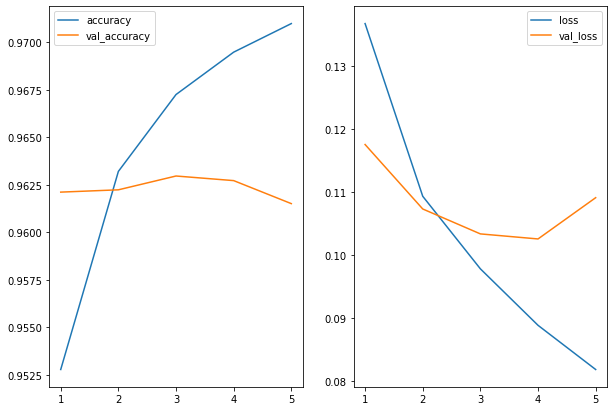

In [43]:
plot_loss_curves(history_2)